<center><H2>Entity Recognition and Classification

<H4>Description:</H4> This notebook extracts and classifies named entities from structured / unstructured financial transaction data. The extracted entities include individuals, corporates, non-profit organizations, government agencies and PEP. Five LLMs (Mistral, Google's Gemma 3, Deepseek R1, Meta's Llama-3.3 and Microsoft's Phi-3) with free API access and entity recognition capabilities were tested and evaluated based on precision, recall, and F1 score

In [1]:
from openai import OpenAI
import json
import csv
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
class EntityExtractor:
    def __init__(self, api_key, model, base_url="https://openrouter.ai/api/v1"):
        self.client = OpenAI(
            base_url=base_url,
            api_key=api_key,
        )
        self.model = model

    def extract_entities(self, transaction_text: str) -> str:
        prompt_text = f"""
            Extract all named entities from the following transaction text and classify each entity into one of these categories:
            Person, Politically Exposed Person, Corporation, Government Agency, Non-Profit Organization, or Shell Company.
            - If the entity's category is ambiguous, classify it as "Corporation".
            - Do NOT include IBANs, VPNs, IPs, addresses, account numbers, tax IDs, location, cities, or countries.
            - Banks should be extracted separately (e.g., "Swiss Bank", "Cayman National Bank") without IBAN/account numbers.
            - Include people with titles (Mr., Mrs., Dr., etc.) as Person.
            - Do not output into code block, print as raw text.

            Transaction Text:
            {transaction_text}

            Output Format **(Do not output into code block, print as raw text):**
            Eg: 
            [
                {{
                    "entity": "Acme Corp",
                    "category": "Corporation"
                }},
                    {{
                    "entity": "SovCo Capital Partners",
                    "category": "Corporation"
                    }}
            ]
        
            """
        completion = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt_text
                        }
                    ]
                }
            ]
        )
        return completion.choices[0].message.content


In [3]:
api_key = os.getenv("OpenRouter_APIKEY")

In [ ]:
with open("Data/unstructured_data.txt", "r", encoding="utf-8") as f:
    content = f.read()
    transactions = [t.strip() for t in content.split('---') if t.strip()]

In [ ]:
with open("Data/structured_data.csv", newline = "", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if "TransactionText" in row:
            txn_text = row["TransactionText"]
        else:
            txn_text = "\n".join(f"{key}: {value}" for key, value in row.items())
            transactions.append(txn_text)

In [6]:
def compute_metrics(ground_truth, prediction):
    gt_set = {(item["entity"].strip().lower(), item["category"].strip().lower()) for item in ground_truth}
    pred_set = {(item["entity"].strip().lower(), item["category"].strip().lower()) for item in prediction}

    true_positives = gt_set.intersection(pred_set)
    false_positives = pred_set - gt_set   
    false_negatives = gt_set - pred_set   

    precision = len(true_positives) / len(pred_set) if pred_set else 0
    recall = len(true_positives) / len(gt_set) if gt_set else 0
    if precision + recall:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "true_positives": list(true_positives),
        "false_positives": list(false_positives),
        "false_negatives": list(false_negatives)
    }


In [ ]:
ground_truth_file = "Data/ground_truth.json"

with open(ground_truth_file, "r", encoding="utf-8") as f:
    ground_truth = json.load(f)

In [8]:
def compute_metrics(ground_truth, prediction):
    gt_set = {(item["entity"].strip().lower(), item["category"].strip().lower()) for item in ground_truth}
    pred_set = {(item["entity"].strip().lower(), item["category"].strip().lower()) for item in prediction}

    true_positives = gt_set.intersection(pred_set)
    false_positives = pred_set - gt_set
    false_negatives = gt_set - pred_set

    precision = len(true_positives) / len(pred_set) if pred_set else 0
    recall = len(true_positives) / len(gt_set) if gt_set else 0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "true_positives": list(true_positives),
        "false_positives": list(false_positives),
        "false_negatives": list(false_negatives)
    }

In [9]:
def average_metrics(metrics_list):
    total_precision = total_recall = total_f1 = 0
    n = len(metrics_list)
    for m in metrics_list:
        total_precision += m["precision"]
        total_recall += m["recall"]
        total_f1 += m["f1"]
    return {
        "Precision": total_precision / n if n else 0,
        "Recall": total_recall / n if n else 0,
        "F1-Score": total_f1 / n if n else 0
    }

In [10]:
def evaluate_transactions(transactions, ground_truths, extractor, max_attempts=15):
    all_results = []
    metrics_results = []
    
    for idx, (txn, gt) in enumerate(zip(transactions, ground_truths), start=1):
        print(f"\n=== Transaction {idx} ===")
        attempts = 0
        valid_prediction = None
        last_result = None
        
        while attempts < max_attempts:
            result = extractor.extract_entities(txn)
            last_result = result
            try:
                prediction = json.loads(result)
                valid_prediction = prediction
                break 
            except Exception as e:
                attempts += 1
                lines = result.splitlines()
                if len(lines) > 2:
                    trimmed = "\n".join(lines[1:-1]).strip()
                    try:
                        prediction = json.loads(trimmed)
                        valid_prediction = prediction
                        break
                    except:
                        pass
        
        if valid_prediction is not None:
            print("Predicted Entities:")
            print(json.dumps(valid_prediction, indent=4))
            txn_metrics = compute_metrics(gt, valid_prediction)
            metrics_results.append(txn_metrics)
            all_results.append({
                "transaction": txn,
                "prediction": valid_prediction,
                "metrics": txn_metrics
            })
        else:
            print("Failed to recognize entities")
            all_results.append({
                "transaction": txn,
                "prediction": last_result,
                "metrics": None
            })
    
    if metrics_results:
        avg = average_metrics(metrics_results)
    else:
        avg = None
    
    return all_results, avg


<H3>Model-1: Mistral-Small-3.1-24B-Instruct</H3>

In [11]:
model = "mistralai/mistral-small-3.1-24b-instruct:free" 
extractor = EntityExtractor(api_key, model)

In [12]:
M1_results, M1_metrics = evaluate_transactions(transactions, ground_truth, extractor)


=== Transaction 1 ===
Predicted Entities:
[
    {
        "entity": "Global Horizon Consulting LLC",
        "category": "Corporation"
    },
    {
        "entity": "Swiss Bank",
        "category": "Bank"
    },
    {
        "entity": "Bright Future Nonprofit Inc",
        "category": "Non-Profit Organization"
    },
    {
        "entity": "Cayman National Bank",
        "category": "Bank"
    },
    {
        "entity": " Quantitative Holding Ltd",
        "category": "Corporation"
    },
    {
        "entity": "Ali Al-Mansoori",
        "category": "Person"
    }
]

=== Transaction 2 ===
Predicted Entities:
[
    {
        "entity": "Quantum Holdings Ltd",
        "category": "Corporation"
    },
    {
        "entity": "Maria Gonzalez",
        "category": "Person"
    },
    {
        "entity": "Golden Sands Trading FZE",
        "category": "Corporation"
    },
    {
        "entity": "Deutsche Bank Frankfurt",
        "category": "Bank"
    },
    {
        "entity": "Emirat

In [13]:
print("\n=== Mistral-Small-3.1-24B-Instruct ===")
print(f"Precision: {M1_metrics['Precision'] * 100:.2f}%")
print(f"Recall:    {M1_metrics['Recall'] * 100:.2f}%")
print(f"F1 Score:  {M1_metrics['F1-Score'] * 100:.2f}%")


=== Mistral-Small-3.1-24B-Instruct ===
Precision: 85.71%
Recall:    84.01%
F1 Score:  84.80%


<H3>Model-2: Gemma-3-27B-it

In [14]:
model = "google/gemma-3-27b-it:free" 
extractor = EntityExtractor(api_key, model)

In [15]:
M2_results, M2_metrics = evaluate_transactions(transactions, ground_truth, extractor)


=== Transaction 1 ===
Predicted Entities:
[
    {
        "entity": "Global Horizona Consulting LLC",
        "category": "Corporation"
    },
    {
        "entity": "Swiss bank",
        "category": "Bank"
    },
    {
        "entity": "Bright Future Nonprofit Inc",
        "category": "Non-Profit Organization"
    },
    {
        "entity": "Cayman National Bank",
        "category": "Bank"
    },
    {
        "entity": "Mr. Ali Al-Mansoori",
        "category": "Person"
    },
    {
        "entity": "Quantum Holding Ltd",
        "category": "Corporation"
    }
]

=== Transaction 2 ===
Predicted Entities:
[
    {
        "entity": "Quantum Holdings Ltd",
        "category": "Corporation"
    },
    {
        "entity": "Maria Gonzalez",
        "category": "Person"
    },
    {
        "entity": "Golden Sands Trading FZE",
        "category": "Corporation"
    },
    {
        "entity": "Deutsche Bank Frankfurt",
        "category": "Bank"
    },
    {
        "entity": "Emirate

In [16]:
print("\n=== Gemma-3-27b-it ===")
print(f"Precision: {M2_metrics['Precision'] * 100:.2f}%")
print(f"Recall:    {M2_metrics['Recall'] * 100:.2f}%")
print(f"F1 Score:  {M2_metrics['F1-Score'] * 100:.2f}%")


=== Gemma-3-27b-it ===
Precision: 80.95%
Recall:    79.25%
F1 Score:  80.04%


<H3>Model-3: Deepseek-R1-Distill-Qwen-32B

In [17]:
model = "deepseek/deepseek-r1-distill-qwen-32b:free" 
extractor = EntityExtractor(api_key, model)

In [18]:
M3_results, M3_metrics = evaluate_transactions(transactions, ground_truth, extractor)


=== Transaction 1 ===
Predicted Entities:
[
    {
        "entity": "Global Horizona Consulting LLC",
        "category": "Corporation"
    },
    {
        "entity": "Swiss Bank",
        "category": "Corporation"
    },
    {
        "entity": "Bright Future Nonprofit Inc",
        "category": "Non-Profit Organization"
    },
    {
        "entity": "Cayman National Bank",
        "category": "Corporation"
    },
    {
        "entity": "Mr. Ali Al-Mansoori",
        "category": "Person"
    },
    {
        "entity": "Quantum Holding Ltd",
        "category": "Corporation"
    }
]

=== Transaction 2 ===
Predicted Entities:
[
    {
        "entity": "Quantum Holdings Ltd",
        "category": "Corporation"
    },
    {
        "entity": "Maria Gonzalez",
        "category": "Person"
    },
    {
        "entity": "Golden Sands Trading FZE",
        "category": "Corporation"
    },
    {
        "entity": "Deutsche Bank Frankfurt",
        "category": "Corporation"
    },
    {
     

In [19]:
print("\n=== Deepseek-R1-Distill-Qwen-32B ===")
print(f"Precision: {M3_metrics['Precision'] * 100:.2f}%")
print(f"Recall:    {M3_metrics['Recall'] * 100:.2f}%")
print(f"F1 Score:  {M3_metrics['F1-Score'] * 100:.2f}%")


=== Deepseek-R1-Distill-Qwen-32B ===
Precision: 70.41%
Recall:    70.41%
F1 Score:  70.41%


<H3>Model-4: Llama-3.3-70B-Instruct

In [20]:
model = "meta-llama/llama-3.3-70b-instruct:free" 
extractor = EntityExtractor(api_key, model)

In [21]:
M4_results, M4_metrics = evaluate_transactions(transactions, ground_truth, extractor)


=== Transaction 1 ===
Predicted Entities:
[
    {
        "entity": "Global Horizona Consulting LLC",
        "category": "Corporation"
    },
    {
        "entity": "Swiss Bank",
        "category": "Corporation"
    },
    {
        "entity": "Bright Future Nonprofit Inc",
        "category": "Non-Profit Organization"
    },
    {
        "entity": "Cayman National Bank",
        "category": "Corporation"
    },
    {
        "entity": "Mr. Ali Al-Mansoori",
        "category": "Person"
    },
    {
        "entity": "Quantum Holding Ltd",
        "category": "Shell Company"
    }
]

=== Transaction 2 ===
Predicted Entities:
[
    {
        "entity": "Quantum Holdings Ltd",
        "category": "Corporation"
    },
    {
        "entity": "Maria Gonzalez",
        "category": "Person"
    },
    {
        "entity": "Golden Sands Trading FZE",
        "category": "Corporation"
    },
    {
        "entity": "Deutsche Bank",
        "category": "Corporation"
    },
    {
        "enti

In [22]:
print("\n=== Llama-3.3-70B-Instruct ===")
print(f"Precision: {M4_metrics['Precision'] * 100:.2f}%")
print(f"Recall:    {M4_metrics['Recall'] * 100:.2f}%")
print(f"F1 Score:  {M4_metrics['F1-Score'] * 100:.2f}%")


=== Llama-3.3-70B-Instruct ===
Precision: 69.05%
Recall:    68.03%
F1 Score:  68.50%


<H3>Model-5: Phi-3-Medium-128k-Instruct

In [23]:
model = "microsoft/phi-3-medium-128k-instruct:free" 
extractor = EntityExtractor(api_key, model)

In [24]:
M5_results, M5_metrics = evaluate_transactions(transactions, ground_truth, extractor)


=== Transaction 1 ===
Predicted Entities:
[
    {
        "entity": "Global Horizona Consulting LLC",
        "category": "Corporation"
    },
    {
        "entity": "Bright Future Nonprofit Inc",
        "category": "Non-Profit Organization"
    },
    {
        "entity": "Swiss Bank",
        "category": "Bank"
    },
    {
        "entity": "Cayman National Bank",
        "category": "Bank"
    },
    {
        "entity": "Mr. Ali Al-Mansoori",
        "category": "Person"
    },
    {
        "entity": "Quantum Holding Ltd (BVI)",
        "category": "Shell Company"
    }
]

=== Transaction 2 ===
Predicted Entities:
[
    {
        "entity": "Quantum Holdings Ltd",
        "category": "Corporation"
    },
    {
        "entity": "Maria Gonzalez",
        "category": "Person"
    },
    {
        "entity": "Golden Sands Trading FZE",
        "category": "Corporation"
    },
    {
        "entity": "Deutsche Bank Frankfurt (DEUTDEFF)",
        "category": "Corporation"
    },
    {


In [25]:
print("\n===  Phi-3-Medium-128k-Instruct ===")
print(f"Precision: {M5_metrics['Precision'] * 100:.2f}%")
print(f"Recall:    {M5_metrics['Recall'] * 100:.2f}%")
print(f"F1 Score:  {M5_metrics['F1-Score'] * 100:.2f}%")


===  Phi-3-Medium-128k-Instruct ===
Precision: 73.81%
Recall:    72.79%
F1 Score:  73.26%


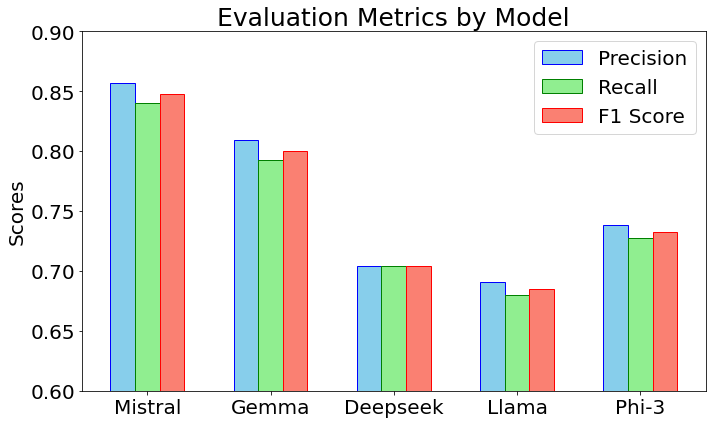

In [26]:
metrics = {
    "Mistral": M1_metrics,
    "Gemma": M2_metrics,
    "Deepseek": M3_metrics,
    "Llama": M4_metrics,
    "Phi-3": M5_metrics
}
models = list(metrics.keys())
precision_vals = [metrics[m]['Precision'] for m in models]
recall_vals = [metrics[m]['Recall'] for m in models]
f1_vals = [metrics[m]['F1-Score'] for m in models]

x = np.arange(len(models))  
width = 0.2  

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision_vals, width, label='Precision', color='skyblue', edgecolor='blue', linewidth=1)
rects2 = ax.bar(x, recall_vals, width, label='Recall', color='lightgreen', edgecolor='green', linewidth=1)
rects3 = ax.bar(x + width, f1_vals, width, label='F1 Score', color='salmon', edgecolor='red', linewidth=1)

ax.set_ylabel('Scores', fontsize=20)
ax.set_title('Evaluation Metrics by Model', fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=20)
ax.tick_params(axis='both', labelsize=20)
ax.legend(fontsize=20)

plt.ylim(0.6, 0.9)
plt.tight_layout()
plt.show()